In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from medmnist import BloodMNIST
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Subset

from data import get_bloodmnist_loader, train_transform
from utils import *

!nvidia-smi

Fri Nov 29 08:17:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:30:00.0 Off |                    0 |
| N/A   43C    P8    16W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
num_classes = 8
val_loader = get_bloodmnist_loader(split='val', batch_size=100, shuffle=False)
test_loader = get_bloodmnist_loader(split='test', batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


In [13]:
train_dataset = BloodMNIST(split='train', download=True, transform=train_transform)

def create_subset(dataset, num_per_class=100):
    class_indices = {i: [] for i in range(len(dataset.info['label']))}
    for idx, (_, label) in enumerate(dataset):
        class_indices[int(label)].append(idx)
    
    subset_indices = []
    for class_id, indices in class_indices.items():
        if len(indices) > num_per_class:
            subset_indices.extend(random.sample(indices, num_per_class))
        else:
            subset_indices.extend(indices)
    
    return Subset(dataset, subset_indices)

subset = create_subset(train_dataset, num_per_class=100)
subset_loader = DataLoader(subset, batch_size=64, shuffle=True)

# subset_class_counts = [0] * len(train_dataset.info['label'])
# for _, label in subset_loader:
#     subset_class_counts[int(label.item())] += 1

# print("Subset size:", len(subset))
# print("Class distribution in subset:", subset_class_counts)


Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist.npz


# Train a ResNet-50 on partial BloodMNIST from scratch

In [18]:
scratch_model = resnet50(pretrained=False)
scratch_model.fc = nn.Linear(scratch_model.fc.in_features, num_classes)
scratch_model.fc.weight.data.normal_(mean=0.0, std=0.01)
scratch_model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(scratch_model.parameters(), 0.001, momentum=0.9, weight_decay=1e-4)

scratch_model = scratch_model.to(device)

val_acc = validate(scratch_model, val_loader, device)
print(f"ResNet50 without pretraining - Val Acc: {val_acc:.2f}% ")

ResNet50 without pretraining - Val Acc: 8.35% 


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


[Epoch 1/10]: Train Loss: 2.1625 Train Acc: 11.38% | Val Acc: 9.81%


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


[Epoch 2/10]: Train Loss: 2.1508 Train Acc: 14.88% | Val Acc: 8.24%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


[Epoch 3/10]: Train Loss: 2.1575 Train Acc: 13.50% | Val Acc: 12.56%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


[Epoch 4/10]: Train Loss: 2.0197 Train Acc: 23.62% | Val Acc: 20.68%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 5/10]: Train Loss: 2.0356 Train Acc: 19.00% | Val Acc: 31.43%


100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


[Epoch 6/10]: Train Loss: 2.0032 Train Acc: 23.12% | Val Acc: 31.72%


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


[Epoch 7/10]: Train Loss: 1.9394 Train Acc: 25.25% | Val Acc: 34.70%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 8/10]: Train Loss: 1.8715 Train Acc: 24.62% | Val Acc: 39.54%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 9/10]: Train Loss: 1.8526 Train Acc: 27.62% | Val Acc: 34.70%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 10/10]: Train Loss: 1.8509 Train Acc: 24.88% | Val Acc: 41.24%


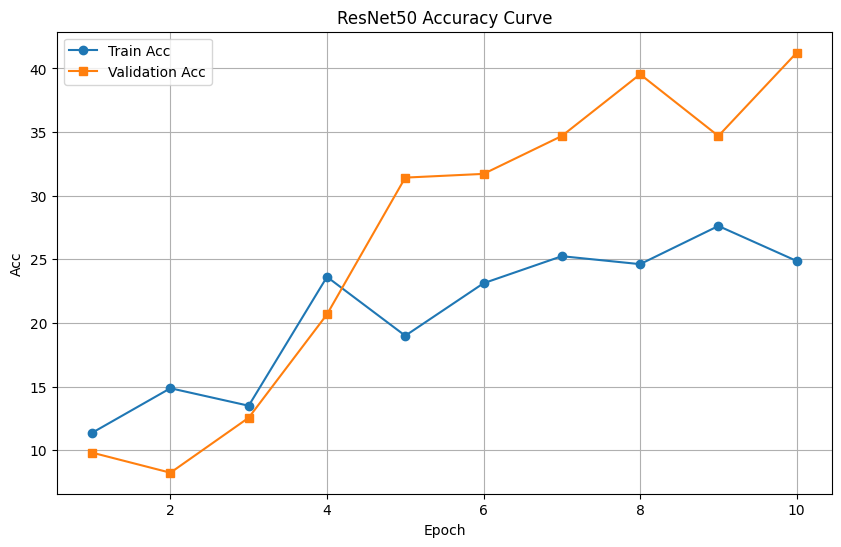

In [19]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(scratch_model, subset_loader, criterion, optimizer, device)
    val_acc = validate(scratch_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('ResNet50 Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_partial_sup_scratch_res50_{num_epochs}e.pth"
torch.save({
    'model_state_dict': scratch_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [21]:
val_acc = validate(scratch_model, val_loader, device)
print(f"ResNet50 without pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(scratch_model, test_loader, device)
print(f"ResNet50 without pretraining - Test Acc: {test_acc:.2f}% ")

ResNet50 without pretraining - Val Acc: 41.24% 
ResNet50 without pretraining - Test Acc: 42.12% 


# Finetune the Supervised Pretrained ResNet50 on partial BloodMNIST

In [25]:
sup_model = resnet50(pretrained=True)
# for name, param in sup_model.named_parameters():
#     if name not in ["fc.weight", "fc.bias"]:
#         param.requires_grad = False

sup_model.fc = nn.Linear(sup_model.fc.in_features, num_classes)
sup_model.fc.weight.data.normal_(mean=0.0, std=0.01)
sup_model.fc.bias.data.zero_()
sup_model = sup_model.to(device)

parameters = list(filter(lambda p: p.requires_grad, sup_model.parameters()))
optimizer = optim.SGD(sup_model.parameters(), 0.001, momentum=0.9, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

val_acc = validate(sup_model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 16.24% 


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


[Epoch 1/10]: Train Loss: 2.0786 Train Acc: 14.38% | Val Acc: 17.41%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


[Epoch 2/10]: Train Loss: 1.9801 Train Acc: 22.12% | Val Acc: 14.02%


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


[Epoch 3/10]: Train Loss: 1.8622 Train Acc: 39.00% | Val Acc: 15.42%


100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


[Epoch 4/10]: Train Loss: 1.6904 Train Acc: 51.25% | Val Acc: 19.28%


100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


[Epoch 5/10]: Train Loss: 1.5127 Train Acc: 53.38% | Val Acc: 17.35%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 6/10]: Train Loss: 1.2991 Train Acc: 62.62% | Val Acc: 28.39%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 7/10]: Train Loss: 1.1646 Train Acc: 64.25% | Val Acc: 24.77%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 8/10]: Train Loss: 0.9927 Train Acc: 68.12% | Val Acc: 37.38%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 9/10]: Train Loss: 0.9190 Train Acc: 71.12% | Val Acc: 41.24%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 10/10]: Train Loss: 0.9047 Train Acc: 70.75% | Val Acc: 42.76%


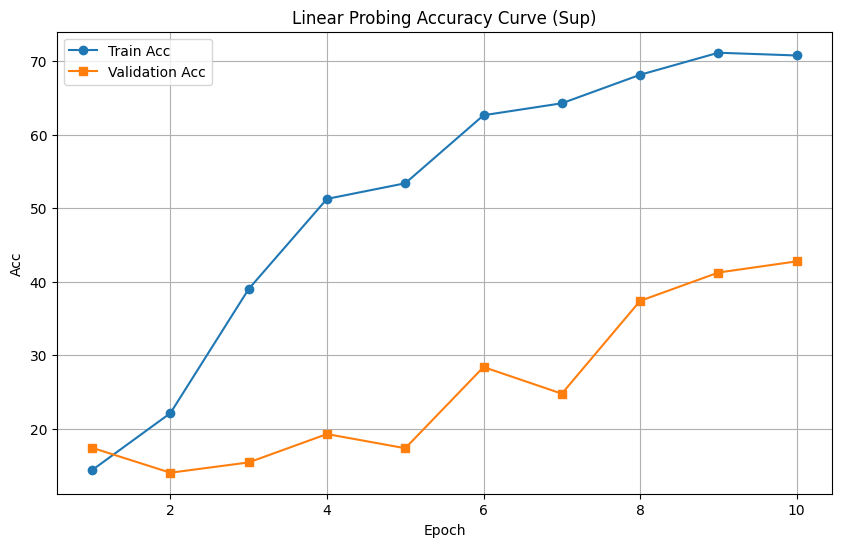

In [26]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(sup_model, subset_loader, criterion, optimizer, device)
    val_acc = validate(sup_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Sup)')
plt.legend()
plt.grid(True)

plt.show()

In [27]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_partial_sup_ft_all_res50_{num_epochs}e.pth"
torch.save({
    'model_state_dict': sup_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [28]:
val_acc = validate(sup_model, val_loader, device)
print(f"ResNet50 with supervised pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(sup_model, test_loader, device)
print(f"ResNet50 with supervised pretraining - Test Acc: {test_acc:.2f}% ")

ResNet50 with supervised pretraining - Val Acc: 42.76% 
ResNet50 with supervised pretraining - Test Acc: 42.36% 


# Finetune the Self-supervised Pretrained ResNet50 on partial BloodMNIST

In [29]:
simsiam_save_path = "/h/lkcai/code/csc_pj_ckpts/checkpoint_0099.pth.tar"
simsiam_state_dict = torch.load(simsiam_save_path)['state_dict']

new_state_dict = {k.replace('module.', ''): v for k, v in simsiam_state_dict.items()}
encoder_state_dict = {
    k.replace('encoder.', ''): v for k, v in new_state_dict.items() if k.startswith('encoder.')}

simsiam_model = resnet50()
simsiam_model.load_state_dict(encoder_state_dict, strict=False)

# for name, param in simsiam_model.named_parameters():
#     if name not in ["fc.weight", "fc.bias"]:
#         param.requires_grad = False

simsiam_model.fc = nn.Linear(simsiam_model.fc.in_features, num_classes)
simsiam_model.fc.weight.data.normal_(mean=0.0, std=0.01)
simsiam_model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

parameters = list(filter(lambda p: p.requires_grad, simsiam_model.parameters()))
optimizer = optim.Adam(simsiam_model.parameters(), 0.01)

simsiam_model = simsiam_model.to(device)

val_acc = validate(simsiam_model, val_loader, device)
print(f"Self-Sup Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Self-Sup Pretrained Classifier with Random head - Val Acc: 4.91% 


100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


[Epoch 1/10]: Train Loss: 2.0922 Train Acc: 12.50% | Val Acc: 19.45%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


[Epoch 2/10]: Train Loss: 1.9869 Train Acc: 21.62% | Val Acc: 7.13%


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


[Epoch 3/10]: Train Loss: 1.8000 Train Acc: 29.62% | Val Acc: 7.13%


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


[Epoch 4/10]: Train Loss: 1.7448 Train Acc: 29.88% | Val Acc: 16.94%


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


[Epoch 5/10]: Train Loss: 1.7008 Train Acc: 33.00% | Val Acc: 26.34%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 6/10]: Train Loss: 1.5934 Train Acc: 39.00% | Val Acc: 24.30%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 7/10]: Train Loss: 1.6290 Train Acc: 37.62% | Val Acc: 37.38%


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


[Epoch 8/10]: Train Loss: 1.6002 Train Acc: 39.00% | Val Acc: 34.00%


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


[Epoch 9/10]: Train Loss: 1.5133 Train Acc: 43.25% | Val Acc: 31.31%


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[Epoch 10/10]: Train Loss: 1.5349 Train Acc: 42.25% | Val Acc: 57.36%


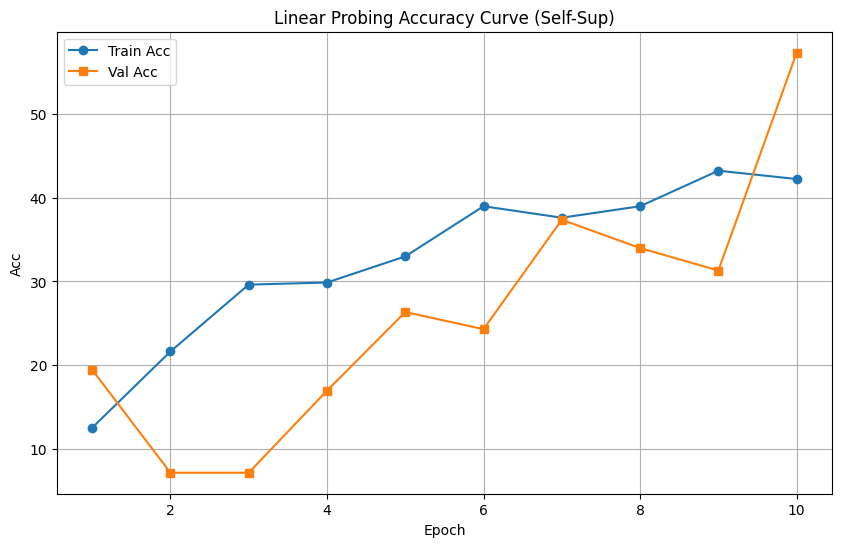

In [30]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(simsiam_model, subset_loader, criterion, optimizer, device)
    val_acc = validate(simsiam_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Val Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Self-Sup)')
plt.legend()
plt.grid(True)

plt.show()

In [31]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_partial_selfsup_ft_all_res50_{num_epochs}e.pth"
torch.save({
    'model_state_dict': simsiam_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [32]:
val_acc = validate(simsiam_model, val_loader, device)
print(f"ResNet50 with Self-supervised pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(simsiam_model, test_loader, device)
print(f"ResNet50 with Self-supervised pretraining - Test Acc: {test_acc:.2f}% ")

ResNet50 with Self-supervised pretraining - Val Acc: 57.36% 
ResNet50 with Self-supervised pretraining - Test Acc: 57.56% 
